Analyzing the Target Data Breach (2013) as documented in Breaking the Target: An Analysis of Target Data Breach and Lessons Learned (https://doi.org/10.48550/arXiv.1701.04940).
Understanding base architecture that was compromised.
Designing three security architectures: Defense in Depth (DiD), Zero Trust, and Adaptive Security.
Creating architecture diagrams using Python's diagrams module.


In [ ]:
# Install the diagrams library
!pip install diagrams

# Import necessary modules
import os
from diagrams import Diagram, Cluster, Edge
from diagrams.onprem.client import Users
from diagrams.onprem.network import Internet, Nginx, Pfsense
from diagrams.onprem.compute import Server
from diagrams.onprem.security import Vault
from diagrams.onprem.monitoring import Prometheus, Grafana
from IPython.display import Image

# Create output directory
if not os.path.exists("cyberarch"):
    os.makedirs("cyberarch")

# Function to display diagrams
def display_diagram(filename):
    image_path = f"cyberarch/{filename}.png"
    display(Image(filename=image_path))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 7.6 MB/s eta 0:00:00


## Base Architecture - Target Data Breach

The Target breach exploited an on-premises network with the following vulnerabilities:
- **Third-Party Vendor Access Portal**: An external portal allowed vendors access, compromised via phishing.
- **Data Staging Servers**: Internal servers with weak authentication were used to aggregate stolen data.
- **Exfiltration Pathway**: Lack of egress filtering enabled data to be moved to external servers.


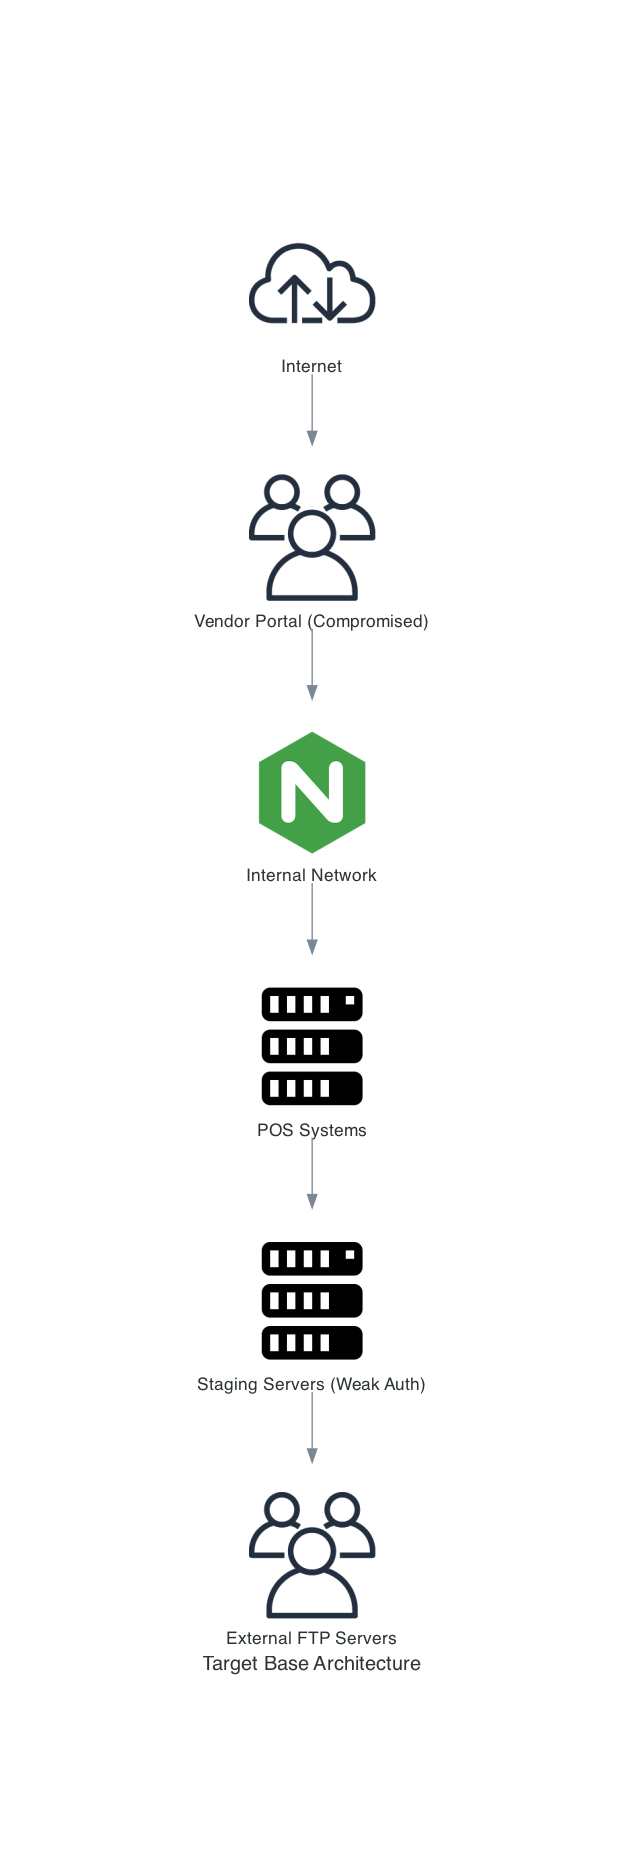

In [ ]:
# Base Architecture Diagram
with Diagram("Target Base Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/target_base"):
    internet = Internet("Internet")
    vendors = Users("Vendor Portal (Compromised)")
    internal_network = Nginx("Internal Network")
    pos = Server("POS Systems")
    staging = Server("Staging Servers (Weak Auth)")
    external = Users("External FTP Servers")
    internet >> vendors >> internal_network >> pos >> staging >> external

display_diagram("target_base")


## Defense in Depth (DiD) Architecture

**Goal**: Implement multiple layers of security controls to protect against breaches.


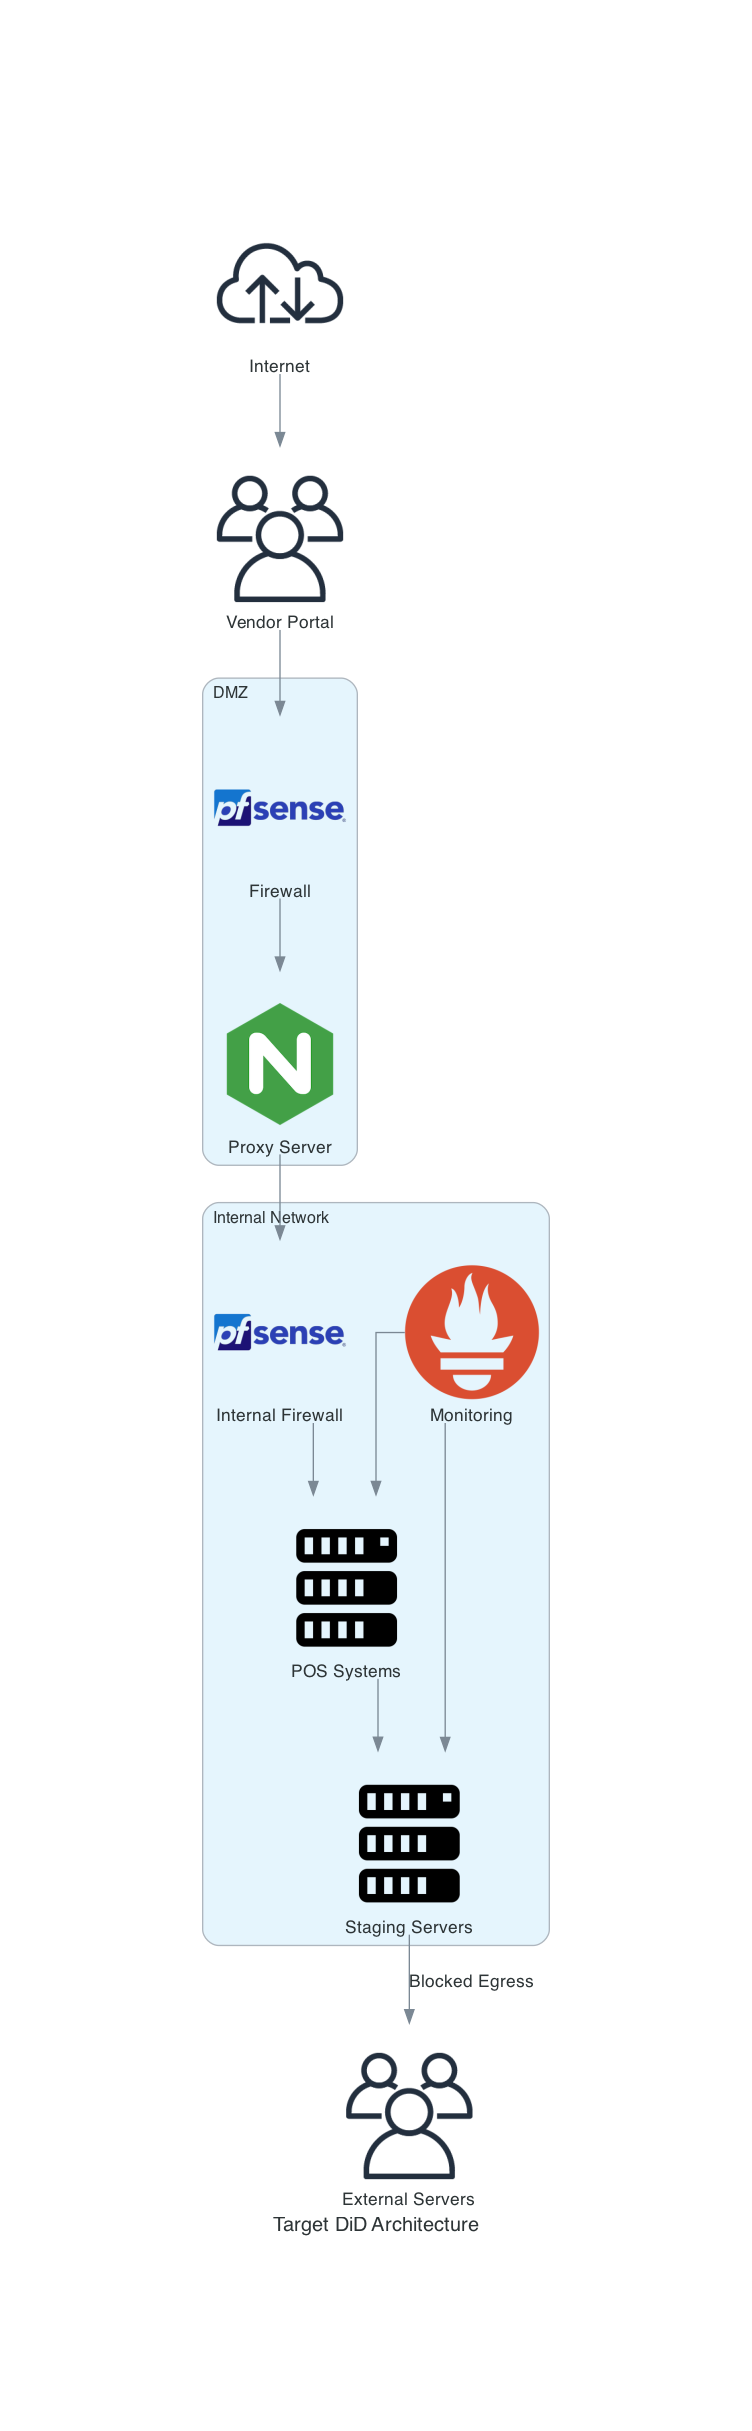

In [ ]:
# Defense in Depth Diagram
with Diagram("Target DiD Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/target_did"):
    internet = Internet("Internet")
    vendors = Users("Vendor Portal")
    with Cluster("DMZ"):
        fw1 = Pfsense("Firewall")
        proxy = Nginx("Proxy Server")
    with Cluster("Internal Network"):
        fw2 = Pfsense("Internal Firewall")
        pos = Server("POS Systems")
        staging = Server("Staging Servers")
        monitoring = Prometheus("Monitoring")
    external = Users("External Servers")
    internet >> vendors >> fw1 >> proxy >> fw2 >> pos >> staging
    monitoring >> pos
    monitoring >> staging
    staging >> Edge(label="Blocked Egress") >> external

display_diagram("target_did")


### DiD Design Decisions

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Network Segmentation         | DMZ and Internal Network (Firewalls)             | Isolates vendor access from internal systems; prevents lateral movement from portal compromise.       |
| 2. Strong Authentication        | Proxy Server, Staging Servers                    | Enforces robust credentials; mitigates weak passwords like 'BackuPuser'.                              |
| 3. Egress Filtering            | Internal Firewall                                | Blocks unauthorized outbound traffic; prevents data exfiltration to external servers.                 |
| 4. Continuous Monitoring        | POS and Staging Servers (Prometheus)             | Detects unusual activity; prevents undetected data aggregation on staging servers.                    |
| 5. Access Controls              | All Internal Systems                             | Limits permissions; ensures least privilege to reduce attack surface from vendor access.              |


## Zero Trust Architecture

**Goal**: Assume no trust, verify every access request regardless of origin.


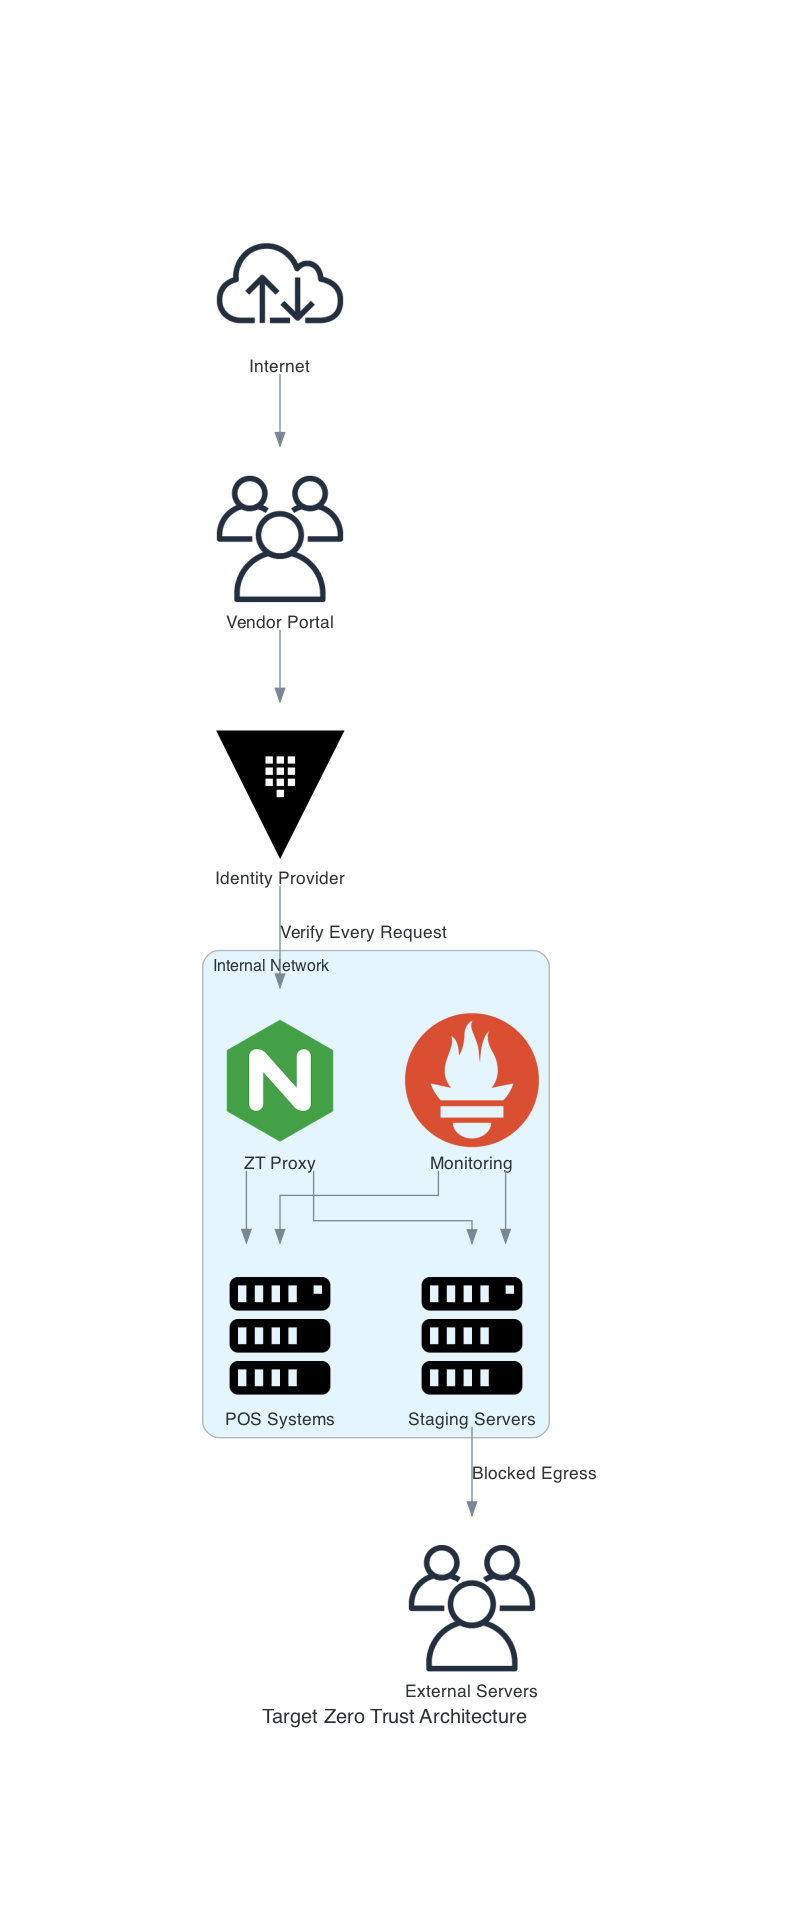

In [ ]:
# Zero Trust Diagram
with Diagram("Target Zero Trust Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/target_zt"):
    internet = Internet("Internet")
    vendors = Users("Vendor Portal")
    idp = Vault("Identity Provider")
    with Cluster("Internal Network"):
        proxy = Nginx("ZT Proxy")
        pos = Server("POS Systems")
        staging = Server("Staging Servers")
        monitoring = Prometheus("Monitoring")
    external = Users("External Servers")
    internet >> vendors >> idp
    idp >> Edge(label="Verify Every Request") >> proxy
    proxy >> pos
    proxy >> staging
    monitoring >> pos
    monitoring >> staging
    staging >> Edge(label="Blocked Egress") >> external

display_diagram("target_zt")


### Zero Trust Design Decisions

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Strict Authentication        | Identity Provider, Proxy                         | Verifies all access; prevents unauthorized entry from compromised vendor credentials.                  |
| 2. Micro-Segmentation           | Internal Network (Proxy to POS/Staging)          | Limits lateral movement; isolates POS and staging servers even if portal is breached.                 |
| 3. Least Privilege Access       | All Systems                                      | Ensures minimal permissions; reduces impact of stolen credentials.                                    |
| 4. Continuous Monitoring        | POS and Staging Servers (Prometheus)             | Validates all activities; detects anomalies like data staging.                                        |
| 5. Egress Control               | Proxy and Network Edge                           | Prevents data exfiltration; blocks outbound traffic unless explicitly authorized.                     |


## Adaptive Security Architecture (ASA)

**Goal**: Dynamically adapt security measures based on real-time threat intelligence.


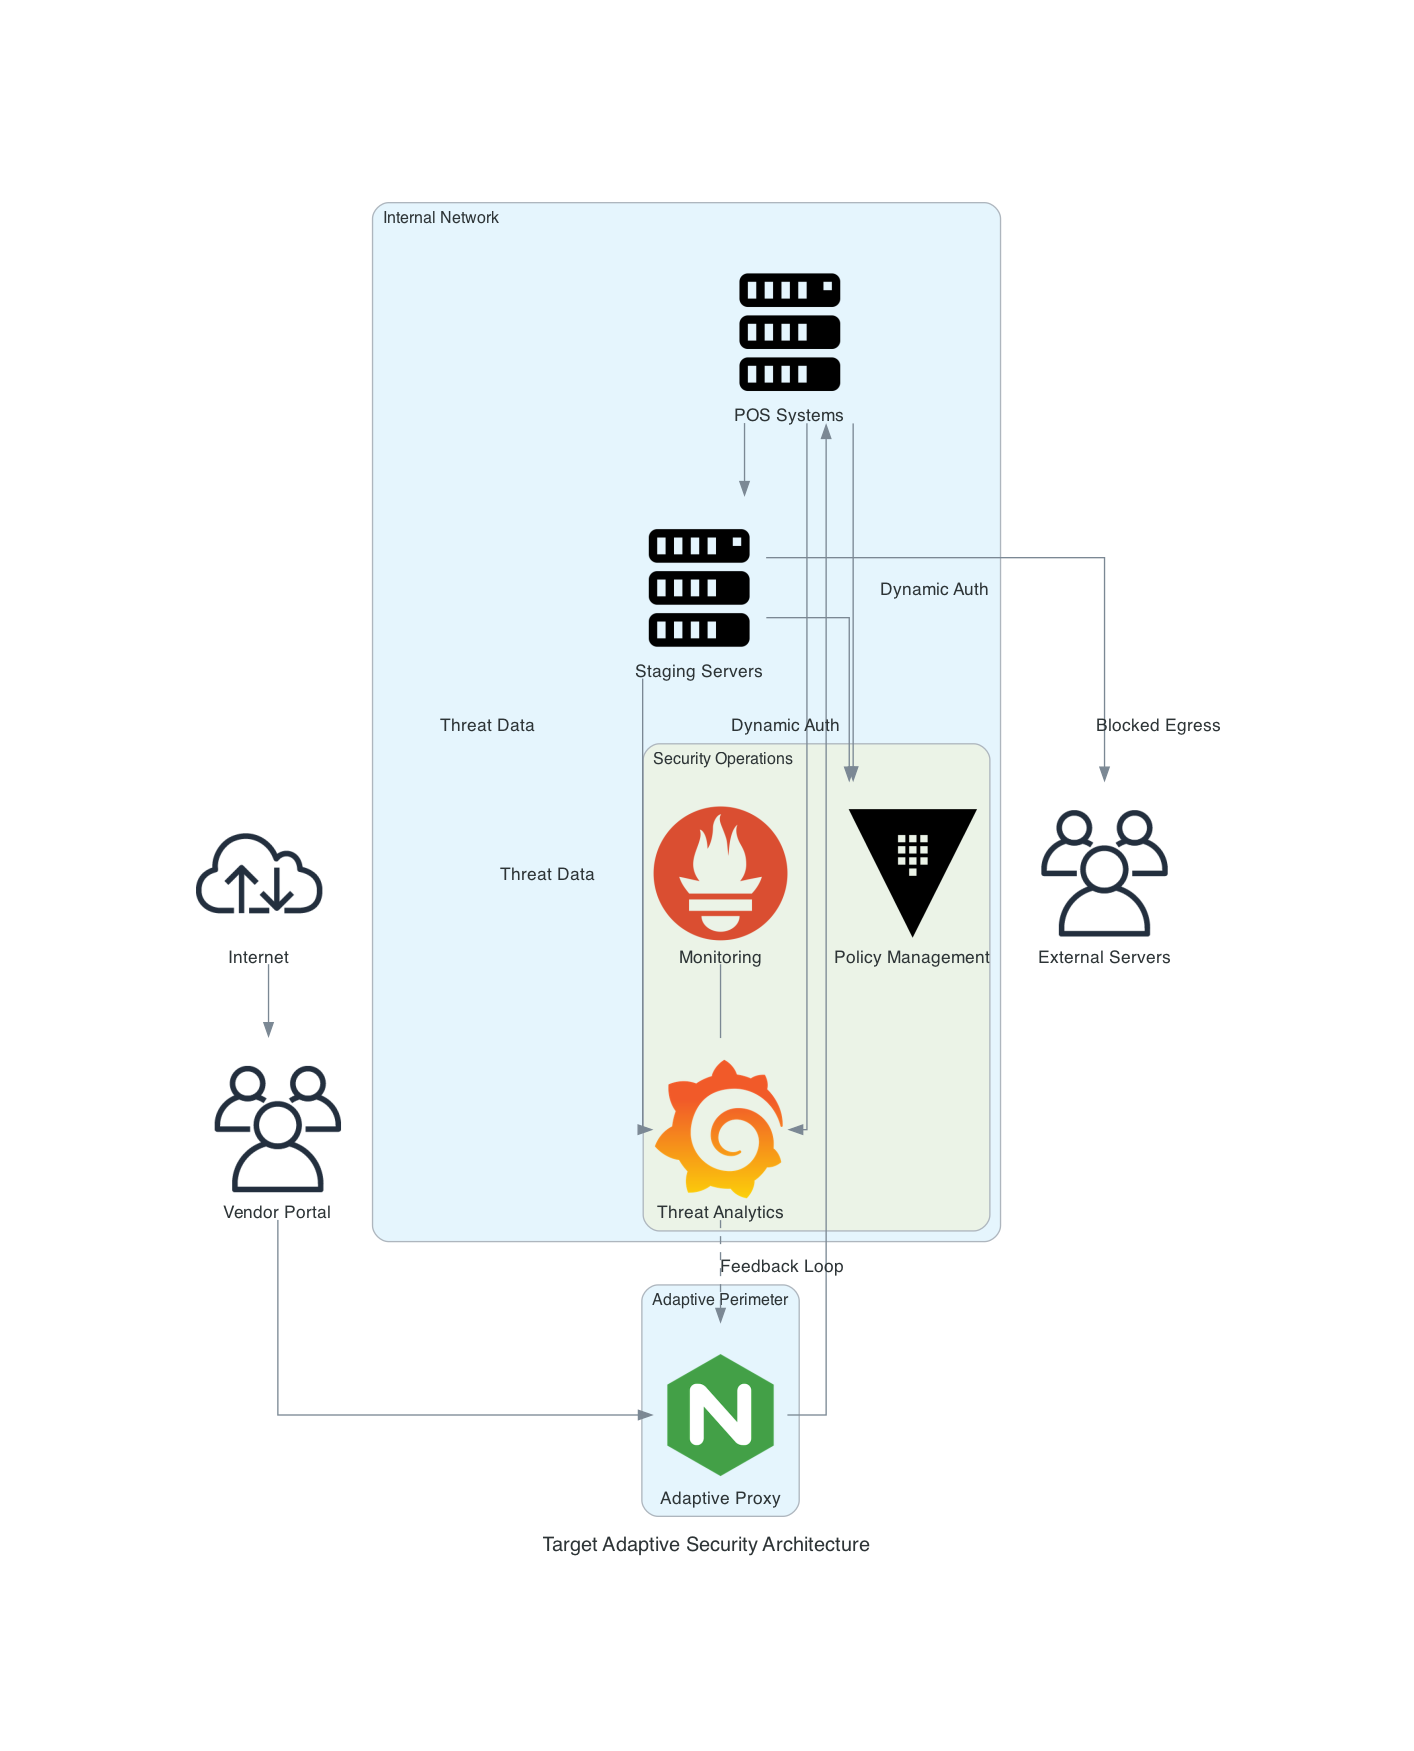

In [ ]:
# Adaptive Security Diagram
with Diagram("Target Adaptive Security Architecture", show=False, direction="TB", outformat="png", filename="cyberarch/target_as"):
    internet = Internet("Internet")
    vendors = Users("Vendor Portal")
    with Cluster("Adaptive Perimeter"):
        proxy = Nginx("Adaptive Proxy")
    with Cluster("Internal Network"):
        pos = Server("POS Systems")
        staging = Server("Staging Servers")
        with Cluster("Security Operations"):
            vault = Vault("Policy Management")
            monitoring = Prometheus("Monitoring") - Grafana("Threat Analytics")
    external = Users("External Servers")
    internet >> vendors >> proxy >> pos >> staging
    pos >> Edge(label="Dynamic Auth") >> vault
    staging >> Edge(label="Dynamic Auth") >> vault
    pos >> Edge(label="Threat Data") >> monitoring
    staging >> Edge(label="Threat Data") >> monitoring
    monitoring >> Edge(label="Feedback Loop", style="dashed") >> proxy
    staging >> Edge(label="Blocked Egress") >> external

display_diagram("target_as")


### Adaptive Security Design Decisions

| **Control**                     | **Where It Applies**                              | **Reason (Rationale)**                                                                                  |
|---------------------------------|--------------------------------------------------|--------------------------------------------------------------------------------------------------------|
| 1. Dynamic Threat Filtering     | Adaptive Proxy                                   | Adjusts rules based on threats; blocks lateral movement from vendor portal.                           |
| 2. Behavioral Analytics         | Monitoring (Prometheus, Grafana)                 | Detects anomalies; prevents undetected staging server activity.                                       |
| 3. Automated Policy Updates     | Policy Management (Vault)                        | Tightens access dynamically; mitigates weak authentication vulnerabilities.                           |
| 4. Real-Time Monitoring         | All Internal Systems                             | Provides immediate visibility; stops exfiltration attempts.                                           |
| 5. Feedback Loop               | Monitoring to Proxy                              | Adapts defenses in real-time; prevents prolonged breaches via egress pathways.                        |


## Conclusion

This analysis demonstrates how Defense in Depth, Zero Trust, and Adaptive Security architectures address the Target Data Breach vulnerabilities. Each design mitigates specific issues—vendor access, weak authentication, and data exfiltration—using layered controls, strict verification, and dynamic adaptation, respectively. The diagrams and tables provide a clear visualization and rationale for these security enhancements.
